In [1]:
import numpy as np
import scipy

import cupy as cp
import cupyx.scipy

import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output, display, HTML
display(HTML("<style>.container { width:90% !important; }</style>")) # just making the notebook cells wider
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))

from importlib import reload
import time

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import cgi_phasec_poppy

import ray
if not ray.is_initialized():
    ray.init(log_to_driver=False)
    
from math_module import xp, ensure_np_array
import iefc_2dm 
import utils
from imshows import *

data_dir = iefc_2dm.iefc_data_dir
response_dir = data_dir/'response-data'

dm1_flat = 2*fits.getdata(cgi_phasec_poppy.data_dir/'dm-acts'/'flatmaps'/'hlc_flattened_dm1.fits')
dm2_flat = 2*fits.getdata(cgi_phasec_poppy.data_dir/'dm-acts'/'flatmaps'/'hlc_flattened_dm2.fits')

# imshow2(dm1_flat/2, dm2_flat/2, 'DM1 Initial State', 'DM2 Initial State', cmap1='viridis', cmap2='viridis')

INFO:numexpr.utils:Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


2023-08-06 12:43:23,640	INFO worker.py:1636 -- Started a local Ray instance.


In [2]:
!nvidia-smi

Wed Aug  2 16:31:48 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100S-PCIE-32GB          On  | 00000000:01:00.0 Off |                    0 |
| N/A   29C    P0              25W / 250W |      4MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

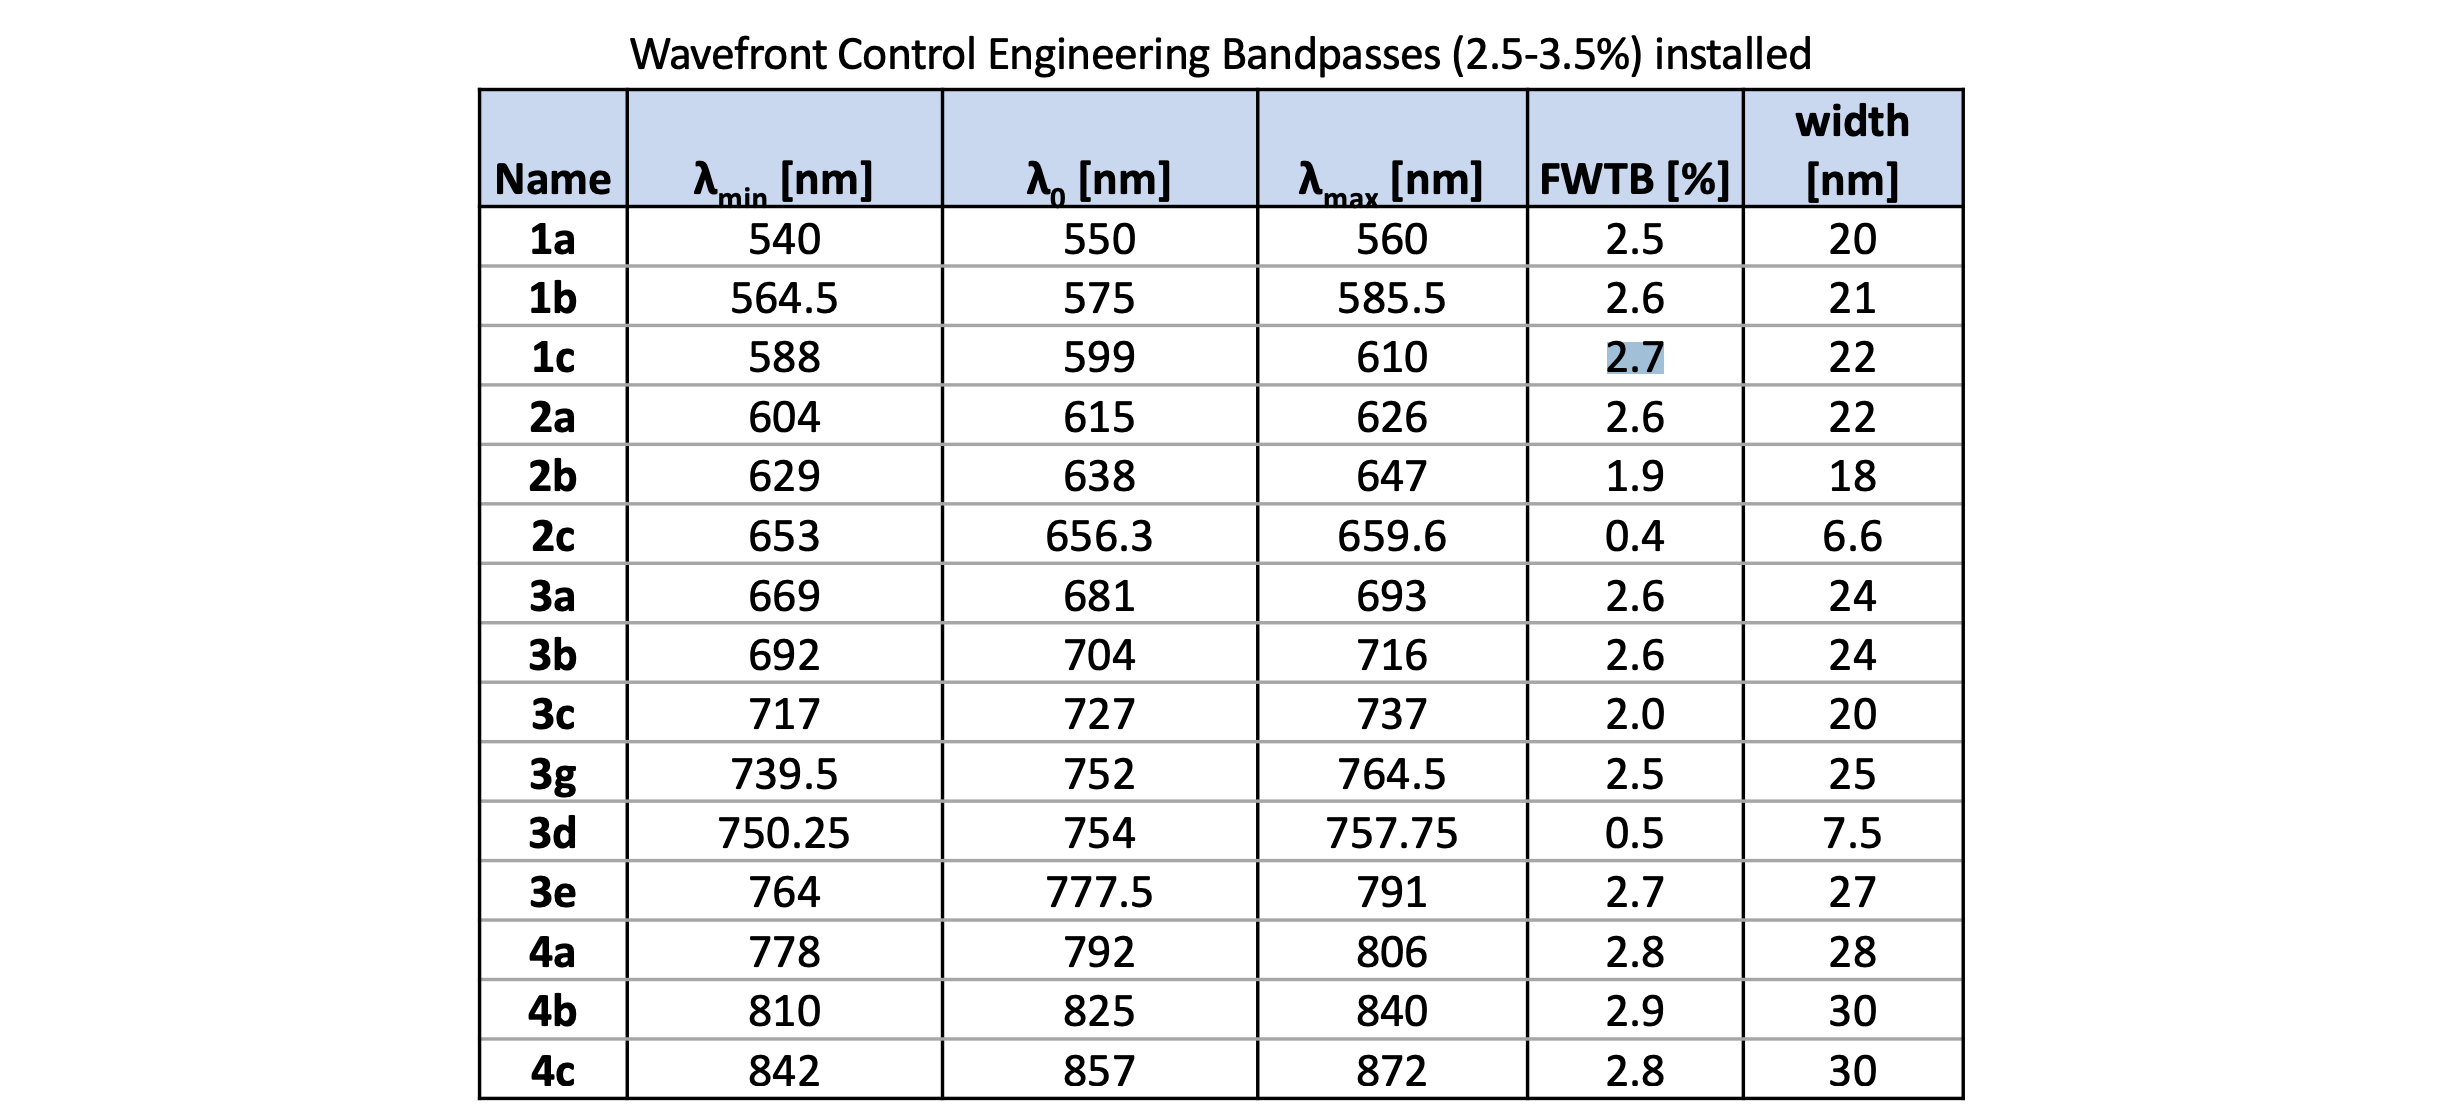

[5.67525e-07 5.75000e-07 5.82475e-07] m
1.0521514041110076e-09 rad
3.4778139958039974e-18 sr
[1.69279798e+08 1.62407413e+08 1.57988052e+08] ph / (s m2)
489675262.413942 ph / (s m2)


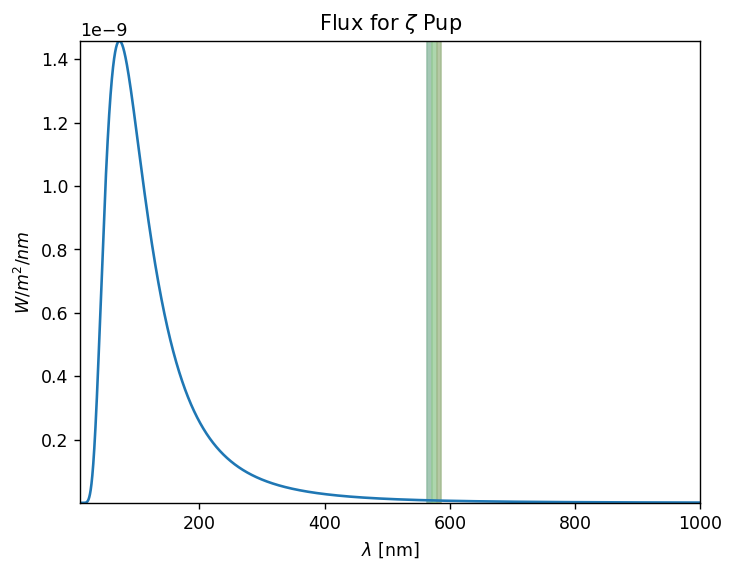

In [3]:
reload(cgi_phasec_poppy.source_flux)

wavelength_c = 575e-9*u.m

nlam = 3
bandwidth = 2.6/100
minlam = wavelength_c * (1 - bandwidth/2)
maxlam = wavelength_c * (1 + bandwidth/2)
wavelengths = np.linspace( minlam, maxlam, nlam )
print(wavelengths)
from astropy.constants import h, c, k_B, R_sun

zpup = cgi_phasec_poppy.source_flux.SOURCE(wavelengths=wavelengths,
                                            temp=40000*u.K,
                                            distance=300*u.parsec,
                                            diameter=2*14*R_sun,
                                            name='$\zeta$ Pup', 
                                            lambdas=np.linspace(10, 1000, 19801)*u.nm,
                                           )

zpup.plot_spectrum()
# zpup.plot_spectrum_ph()

source_fluxes = zpup.calc_fluxes()
print(source_fluxes)
total_flux = np.sum(source_fluxes)
print(total_flux)

In [4]:
reload(cgi_phasec_poppy.cgi)
reload(cgi_phasec_poppy.parallelized_cgi)

rayCGI = ray.remote(cgi_phasec_poppy.cgi.CGI) # make a ray actor class from the original CGI class  

wavelength_c = 575e-9*u.m

kwargs = {
    'cgi_mode':'hlc',
    'use_pupil_defocus':True,
    'use_opds':True,
    'polaxis':10,
}

actors = []
for i in range(nlam):
    actors.append(rayCGI.options(num_cpus=2, num_gpus=1/nlam).remote(**kwargs))
    actors[i].setattr.remote('wavelength', wavelengths[i])
    actors[i].setattr.remote('source_flux', source_fluxes[i])

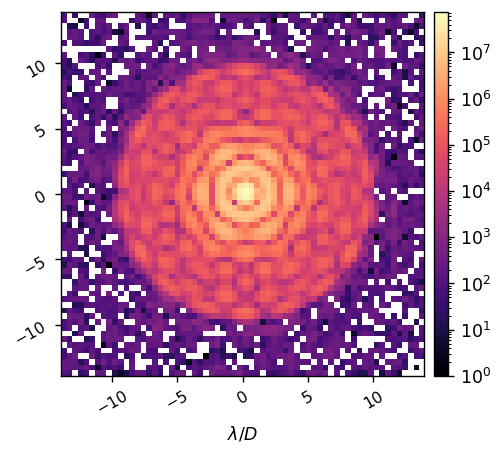

73642046.0


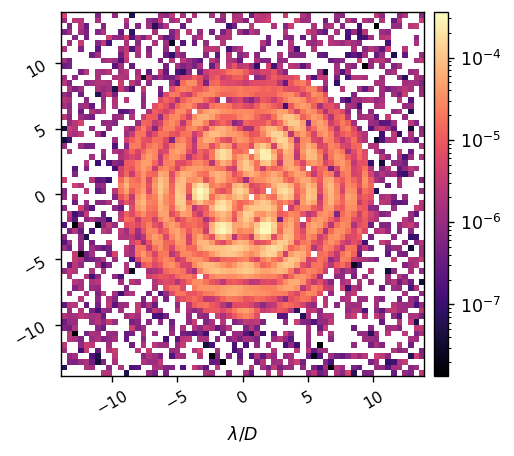

In [5]:
reload(cgi_phasec_poppy.parallelized_cgi)
mode = cgi_phasec_poppy.parallelized_cgi.ParallelizedCGI(actors=actors, dm1_ref=dm1_flat, dm2_ref=dm2_flat)

mode.use_noise = True
mode.exp_time = 2*u.s
mode.dark_current_rate = 0.05*u.electron/u.pix/u.hour
# mode.dark_current_rate = 0.0*u.electron/u.pix/u.hour
mode.read_noise = 120*u.electron/u.pix
# mode.read_noise = 0*u.electron/u.pix
mode.gain = 1

mode.set_actor_attr('use_fpm',False)
ref_unocc_im = mode.snap()
imshow1(ref_unocc_im, pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)

max_ref = xp.max(ref_unocc_im)
print(max_ref)

mode.set_actor_attr('use_fpm',True)
mode.Imax_ref = max_ref

ref_im = mode.snap()
imshow1(ref_im, pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)

# Create dark hole ROI to calibrate and control

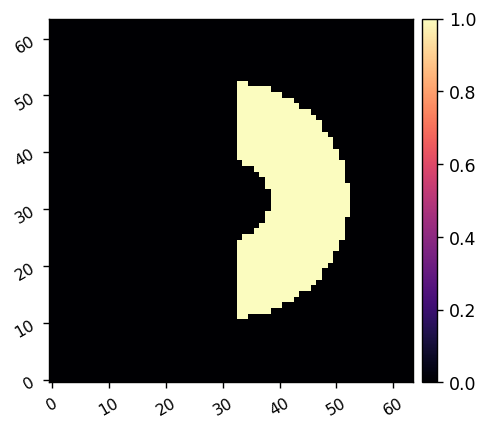

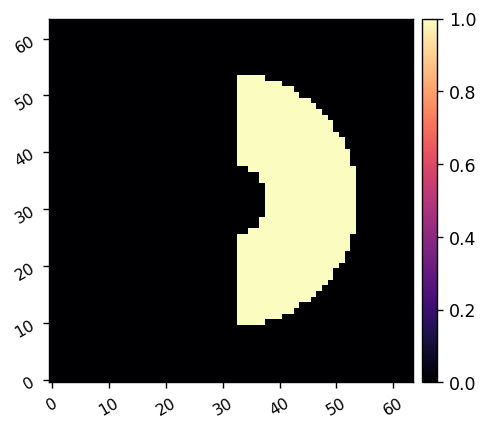

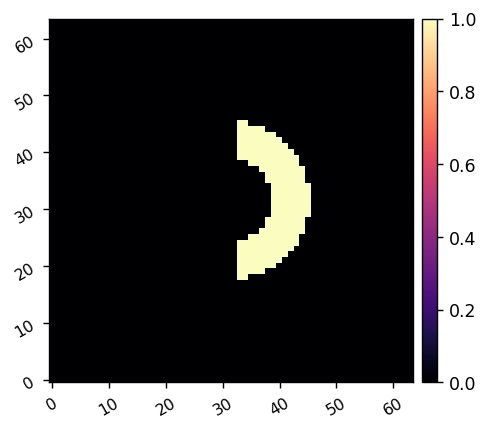

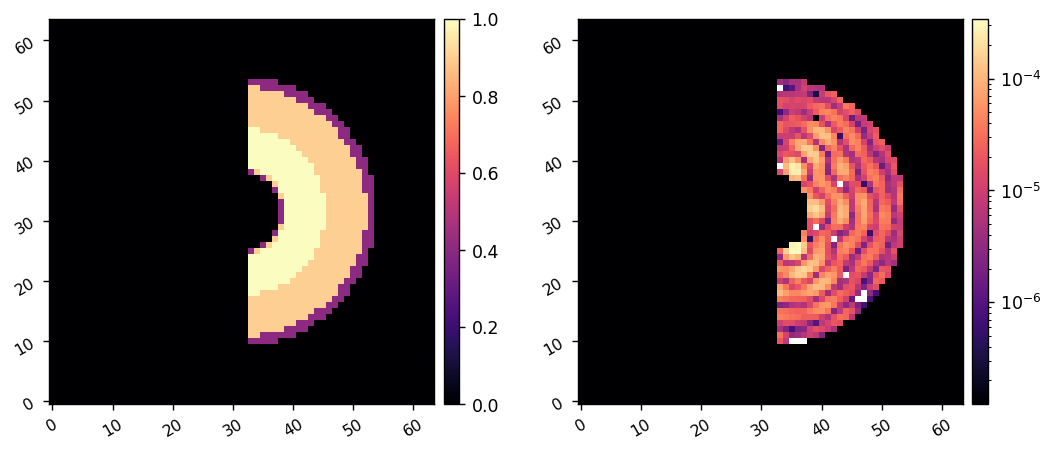

3.19804587449155e-05


In [6]:
reload(utils)
roi1 = utils.create_annular_focal_plane_mask(mode, inner_radius=3, outer_radius=9, edge=0.5, plot=True)
roi2 = utils.create_annular_focal_plane_mask(mode, inner_radius=2.8, outer_radius=9.7, edge=0.5, plot=True)
roi3 = utils.create_annular_focal_plane_mask(mode, inner_radius=3.2, outer_radius=6, edge=0.5, plot=True)

relative_weight_1 = 0.9
relative_weight_2 = 0.4
weight_map = roi3 + relative_weight_1*(roi1*~roi3) + relative_weight_2*(roi2*~roi1*~roi3)
control_mask = weight_map>0
imshow2(weight_map, control_mask*ref_im, lognorm2=True)
mean_ni = xp.mean(ref_im[control_mask])
print(mean_ni)

# Create probe and fourier modes

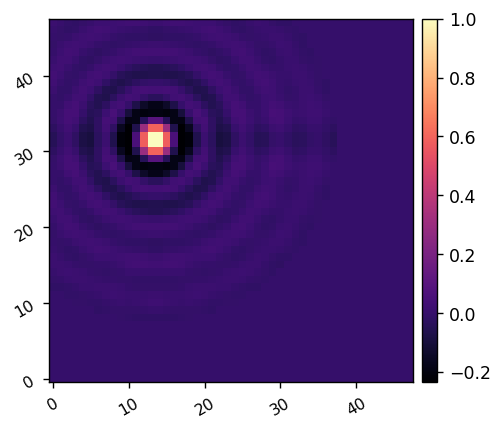

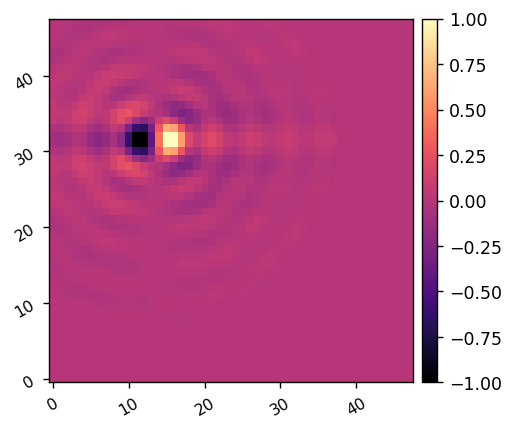

In [7]:
reload(utils)
probe_amp = 2.5e-8
probe_modes = utils.create_fourier_probes(mode, control_mask, fourier_sampling=0.25, shift=(-10,8), nprobes=2, plot=True)

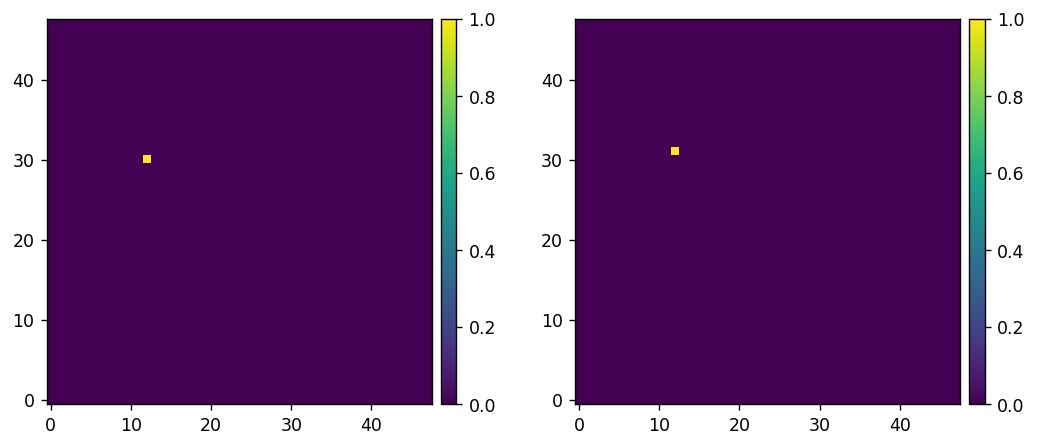

In [18]:
probe_amp = 2.5e-8
# probe_modes = utils.create_poke_probes([(3*mode.Nact//5, mode.Nact//3), (3*mode.Nact//5+1, mode.Nact//3)], plot=True)
probe_modes = utils.create_poke_probes([(12, 30), (12, 31)], plot=True)
# imshow1(probe_modes[0] - probe_modes[1])
# probe_modes = utils.create_poke_probes([(mode.Nact//4, mode.Nact//4), (mode.Nact//2, 3*mode.Nact//4), (3*mode.Nact//4, mode.Nact//4)], plot=True)

In [8]:
calib_amp = 5e-9
calib_modes = utils.create_all_poke_modes(mode.dm_mask)

# import time
# for i in range(Nacts):
#     try:
#         imshow1(calib_modes[i].reshape(mode.Nact,mode.Nact))
#         clear_output(wait=True)
#         time.sleep(0.25)
#     except KeyboardInterrupt:
#         break

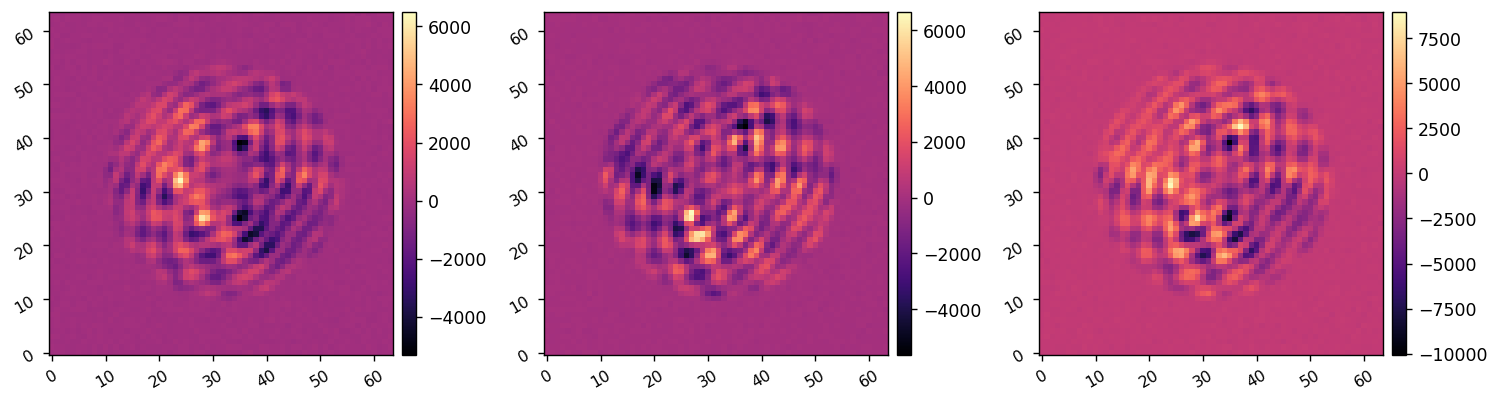

In [9]:
reload(iefc_2dm)

mode.reset_dms()

differential_images, single_images = iefc_2dm.take_measurement(mode, probe_modes, probe_amp, return_all=True)
diff_ims = differential_images.reshape(probe_modes.shape[0], mode.npsf, mode.npsf)
imshow3(diff_ims[0], diff_ims[1], diff_ims[0]-diff_ims[1], wspace=0.35)

In [28]:
reload(iefc_2dm)

response_matrix, response_cube = iefc_2dm.calibrate(mode, 
                                                    control_mask,
                                                    probe_amp, probe_modes, 
                                                    calib_amp, calib_modes, 
                                                    return_all=True)


Calibrating iEFC...


KeyboardInterrupt: 

In [12]:
# date = 20230629
# date = 20230707
date = 20230802
response_matrix = xp.array(fits.getdata(response_dir/f'bbhlc_iefc_2dm_poke_response_matrix_{date}.fits'))
response_cube = xp.array(fits.getdata(response_dir/f'bbhlc_iefc_2dm_poke_response_cube_{date}.fits'))

In [14]:
response_cube.shape

(3608, 2, 4096)

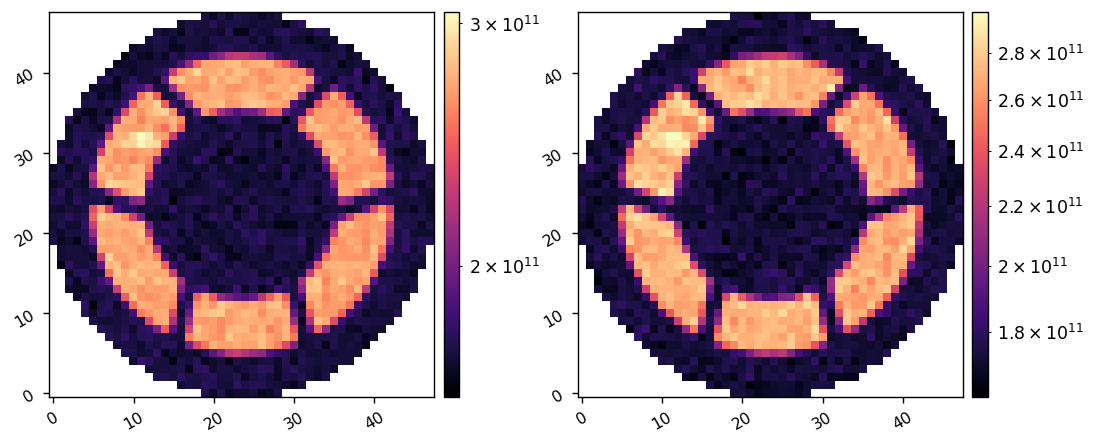

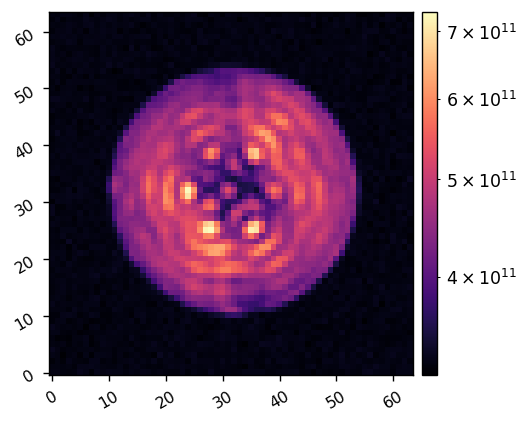

In [16]:
dm1_response = utils.map_acts_to_dm(xp.sqrt(xp.sum(response_matrix[:,:mode.Nacts]**2, axis=0)), mode.dm_mask)
dm2_response = utils.map_acts_to_dm(xp.sqrt(xp.sum(response_matrix[:,mode.Nacts:]**2, axis=0)), mode.dm_mask)
imshow2(dm1_response , dm2_response, lognorm=True)

fp_response = xp.sqrt(xp.sum(abs(response_cube)**2, axis=(0,1))).reshape(mode.npsf, mode.npsf)
imshow1(fp_response, lognorm=True)

# Run IEFC

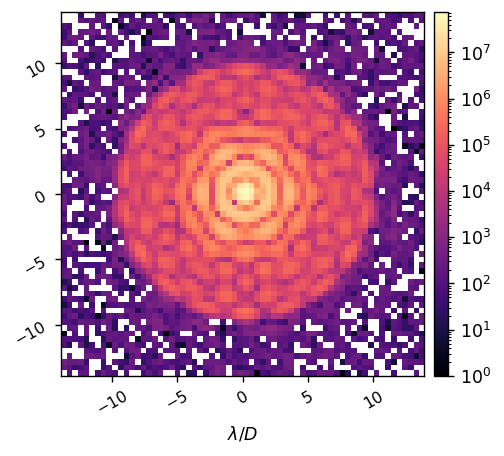

73643179.0


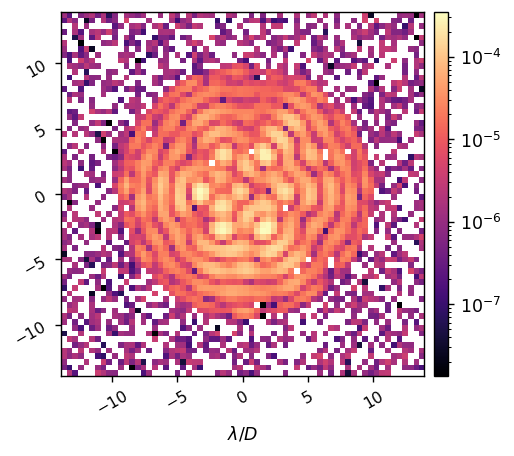

In [26]:
mode.reset_dms()

mode.exp_time = 2*u.s
mode.Imax_ref = None

mode.set_actor_attr('use_fpm',False)
ref_unocc_im = mode.snap()
imshow1(ref_unocc_im, pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)

max_ref = xp.max(ref_unocc_im)
print(max_ref)

mode.set_actor_attr('use_fpm',True)
mode.Imax_ref = max_ref

new_ref_im = mode.snap()
imshow1(new_ref_im, pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)

Running iEFC...
	Closed-loop iteration 1 / 5
	Mean NI of this iteration: 1.289e-05


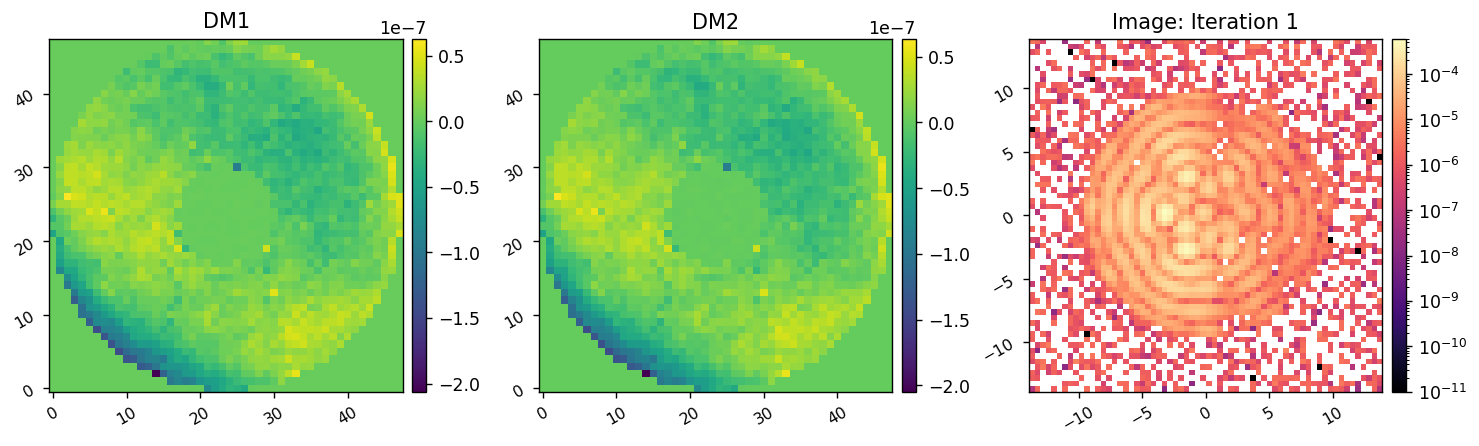

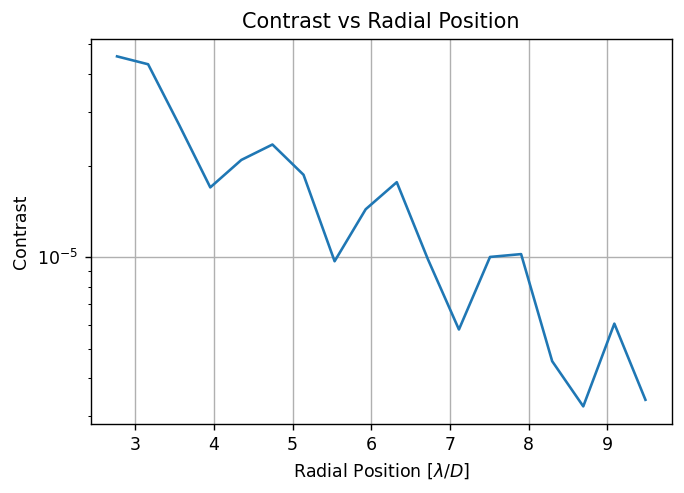

	Closed-loop iteration 2 / 5
	Mean NI of this iteration: 6.180e-06


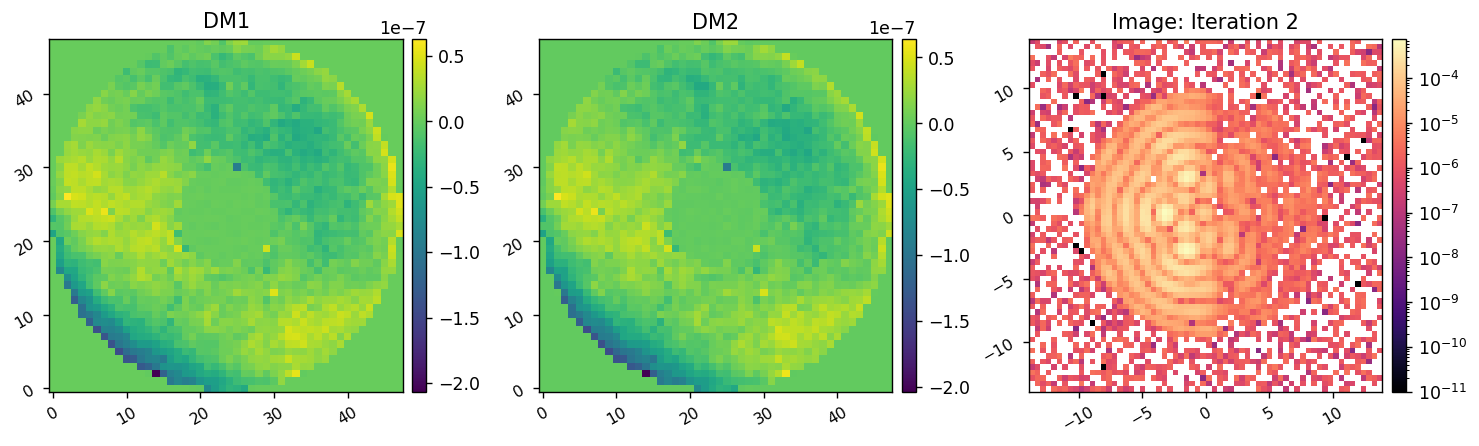

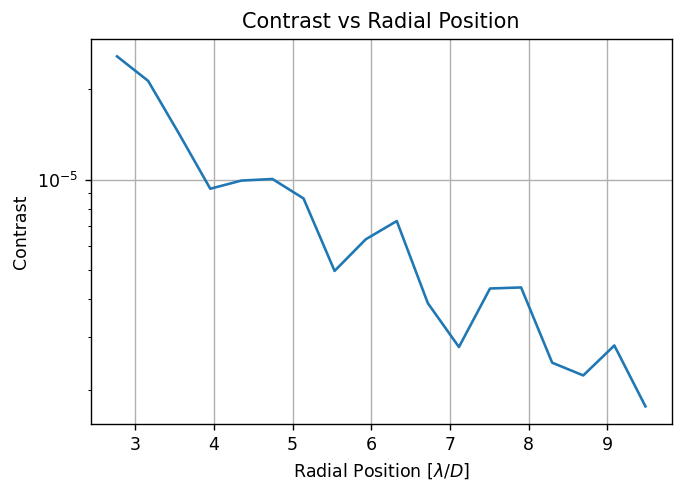

	Closed-loop iteration 3 / 5
	Mean NI of this iteration: 3.665e-06


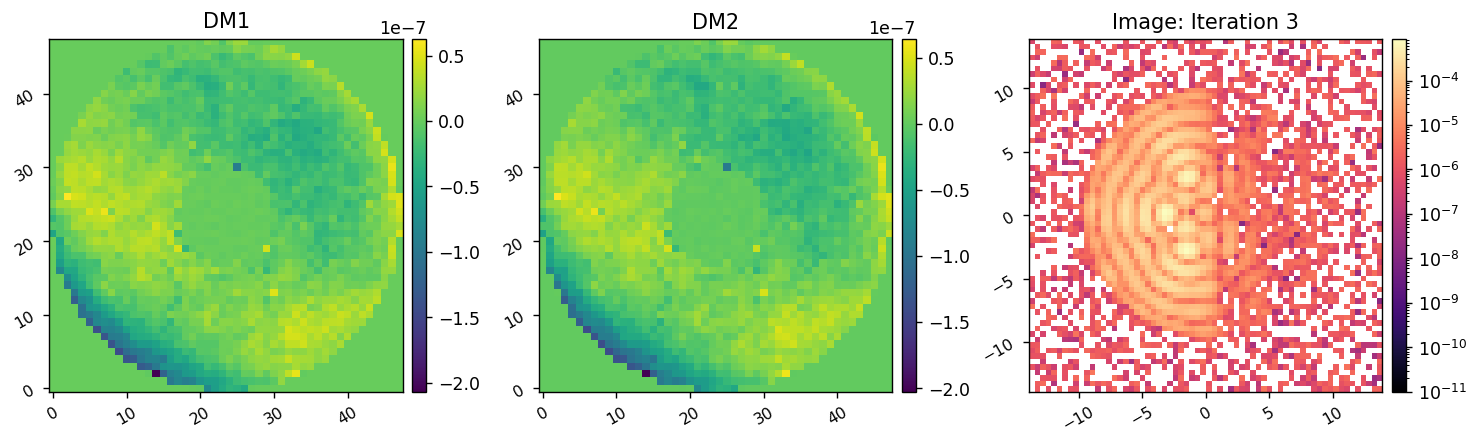

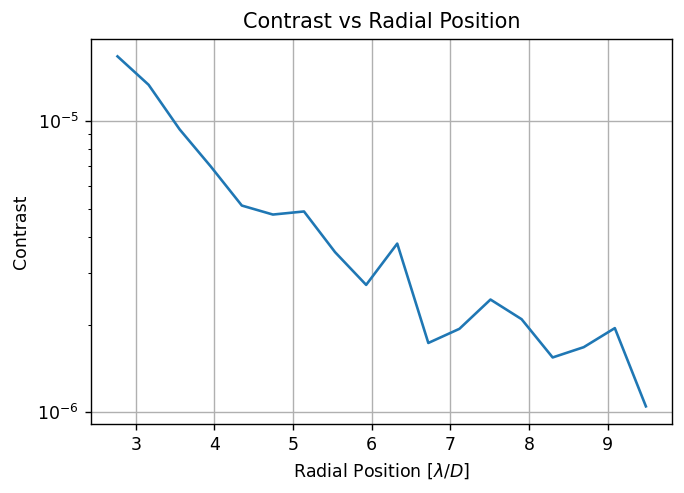

	Closed-loop iteration 4 / 5
	Mean NI of this iteration: 2.408e-06


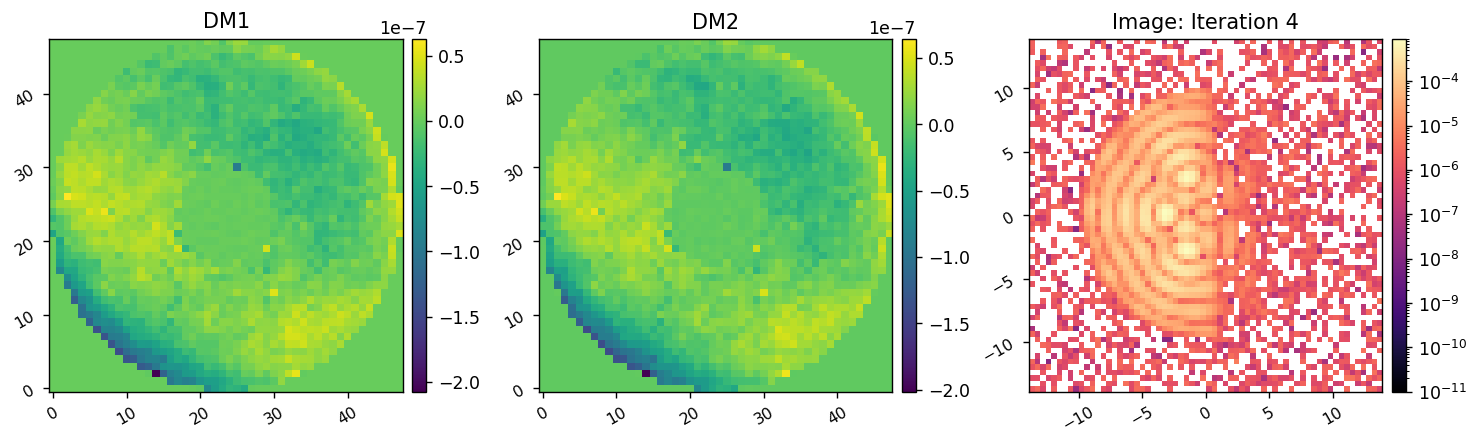

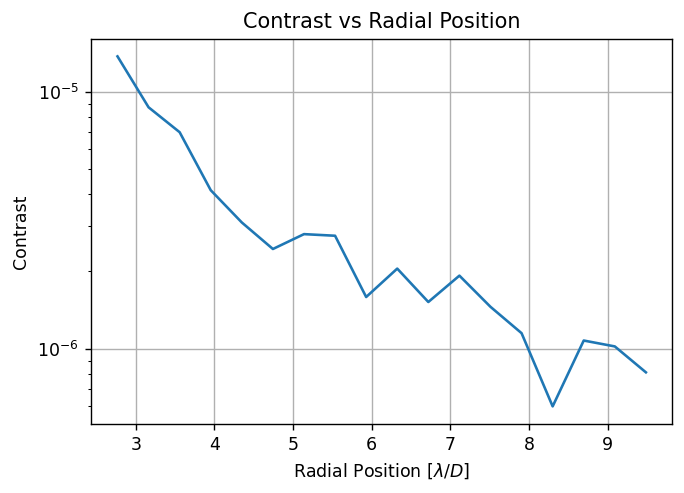

	Closed-loop iteration 5 / 5
	Mean NI of this iteration: 1.997e-06


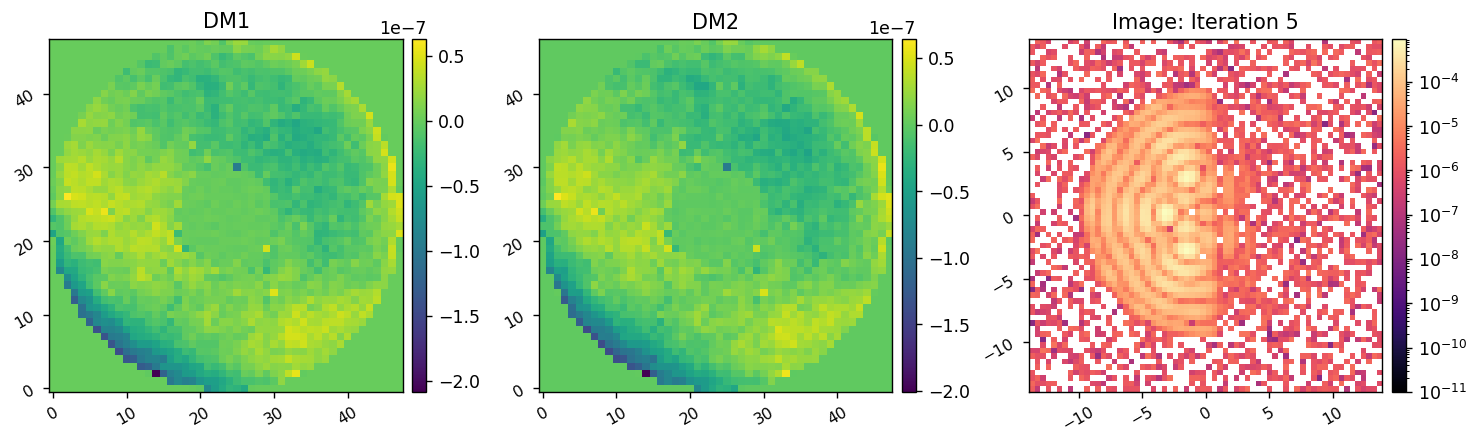

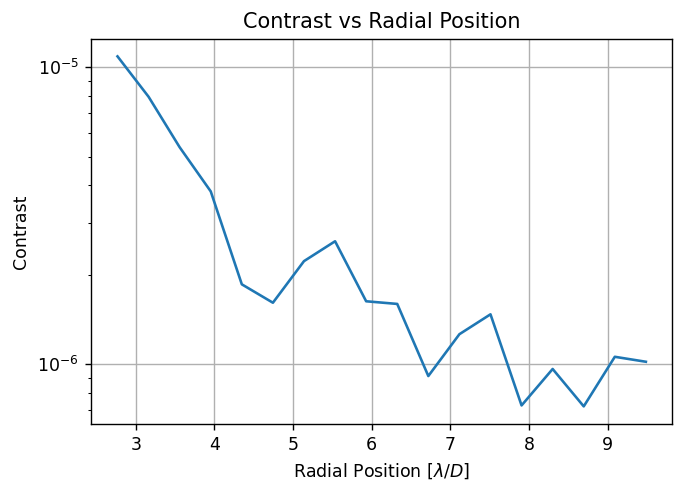

Closed loop for given control matrix completed in 19.749s.


In [27]:
reload(iefc_2dm)
reload(utils)

mode.reset_dms()

reg_cond = 1e-2
control_matrix = utils.WeightedLeastSquares(response_matrix, rcond=reg_cond, weight_map=weight_map, nprobes=probe_modes.shape[0])

images, dm1_commands, dm2_commands = iefc_2dm.run(mode, 
                                          control_matrix,
                                          probe_modes, 
                                          probe_amp, 
                                          ensure_np_array(calib_modes),
                                          control_mask, 
                                          num_iterations=5, 
                                          loop_gain=0.5, 
                                          leakage=0,
                                          plot_all=True,
                                         plot_radial_contrast=True
                                         )

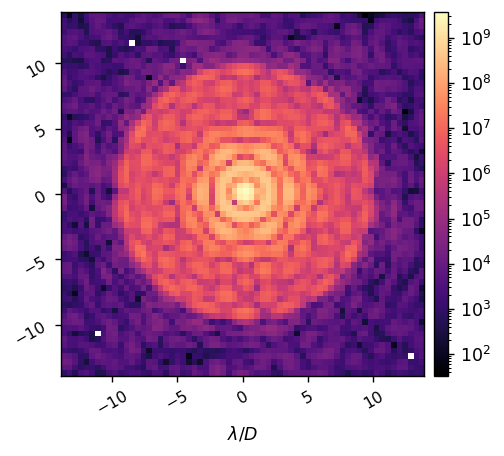

3663249976.0


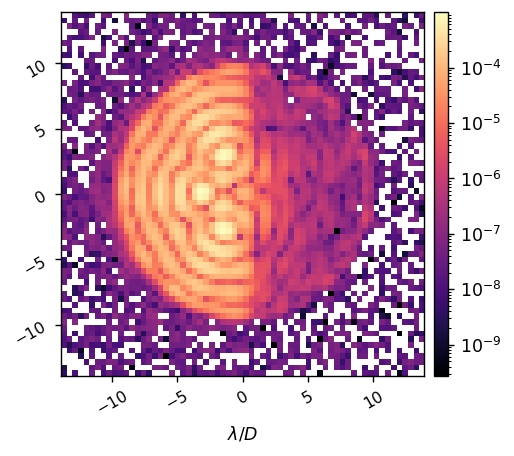

In [34]:
mode.exp_time = 100*u.s
mode.Imax_ref = None

mode.set_actor_attr('use_fpm',False)
ref_unocc_im = mode.snap()
imshow1(ref_unocc_im, pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)

max_ref = xp.max(ref_unocc_im)
print(max_ref)

mode.set_actor_attr('use_fpm',True)
mode.Imax_ref = max_ref

new_ref_im = mode.snap()
imshow1(new_ref_im, pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)

Running iEFC...
	Closed-loop iteration 27 / 36
	Mean NI of this iteration: 1.314e-06


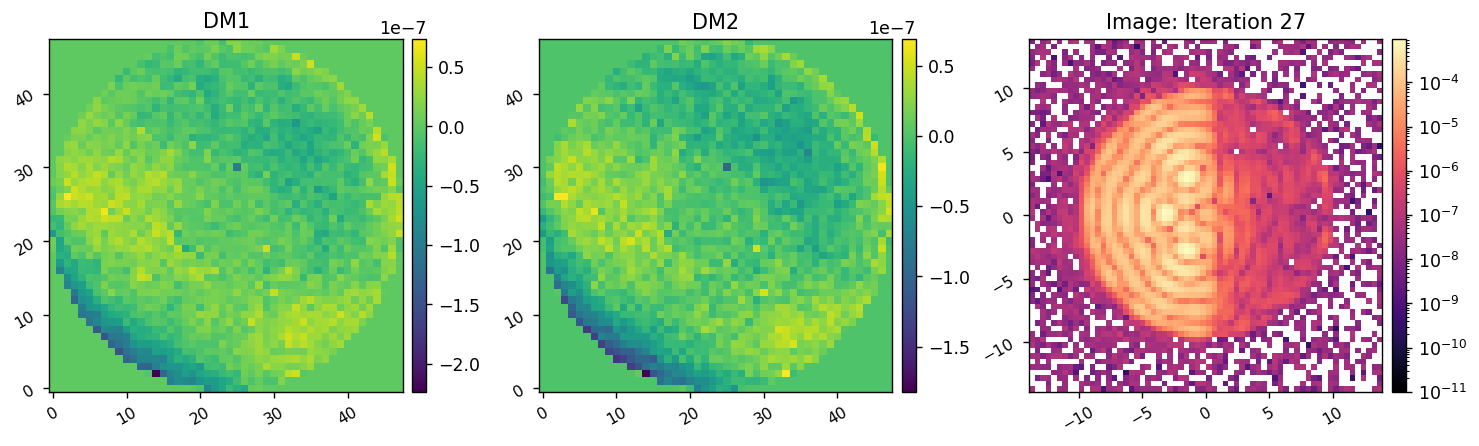

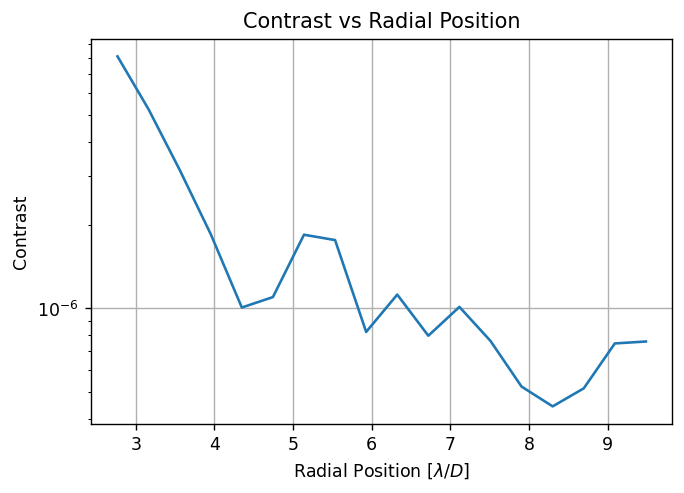

	Closed-loop iteration 28 / 36
	Mean NI of this iteration: 1.313e-06


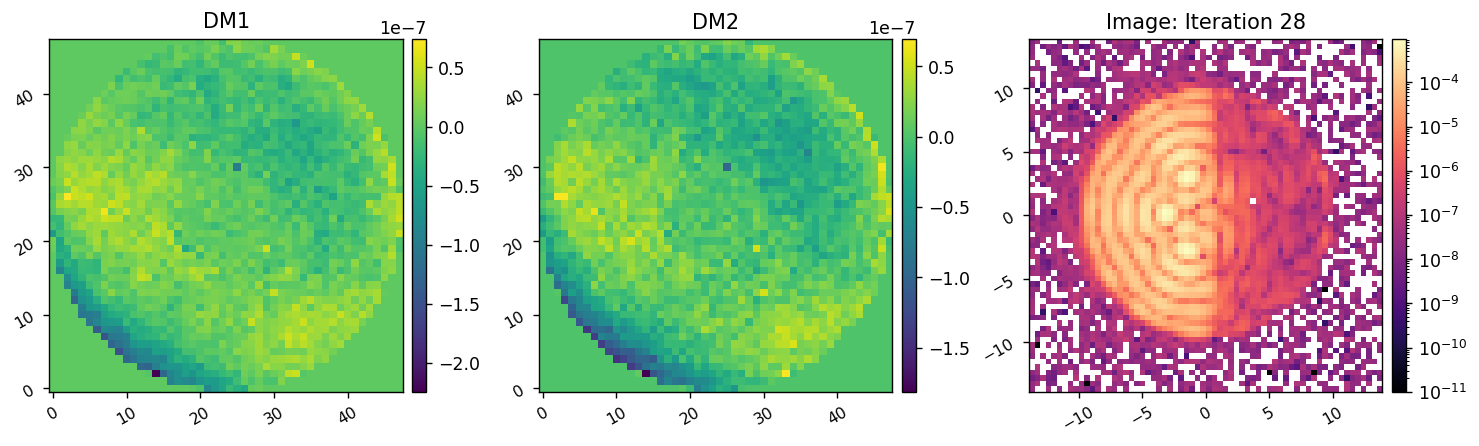

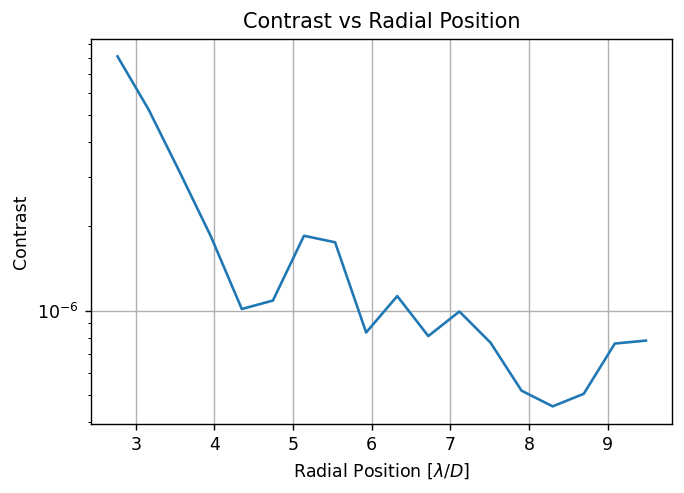

	Closed-loop iteration 29 / 36
	Mean NI of this iteration: 1.317e-06


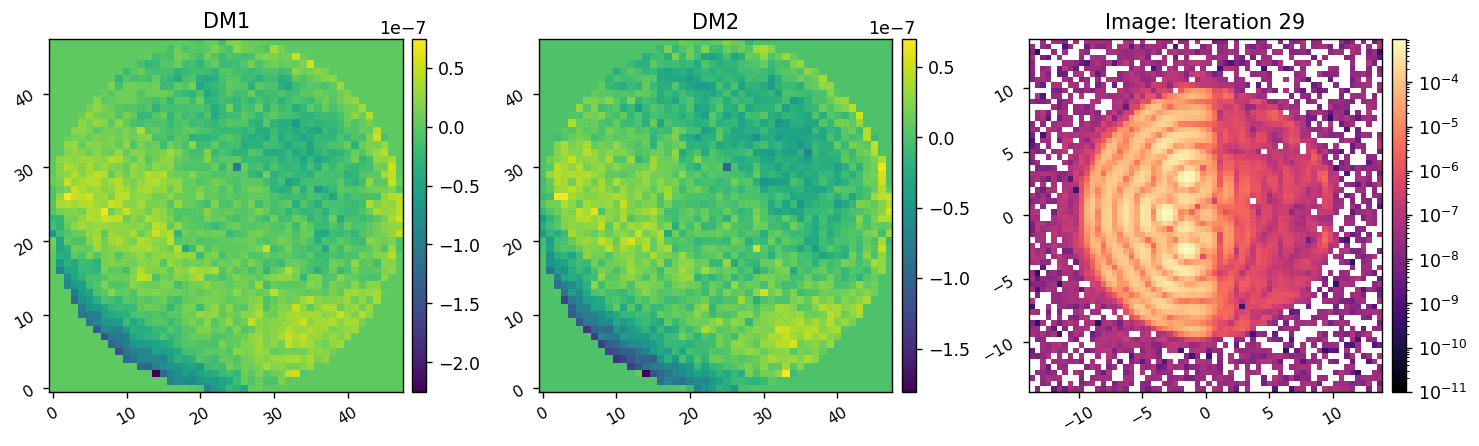

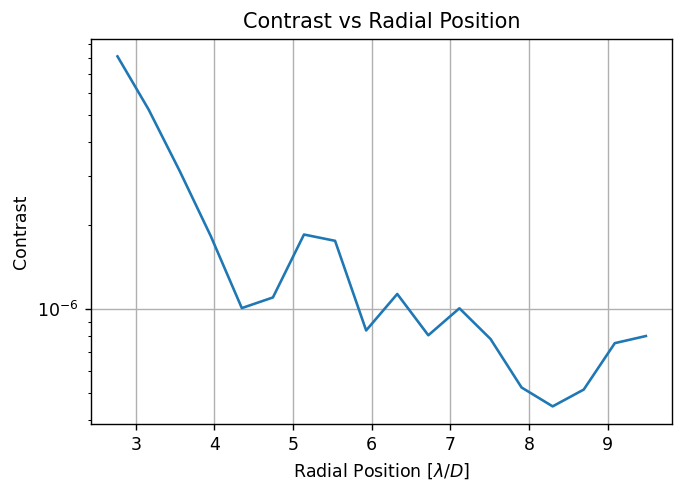

	Closed-loop iteration 30 / 36
	Mean NI of this iteration: 1.318e-06


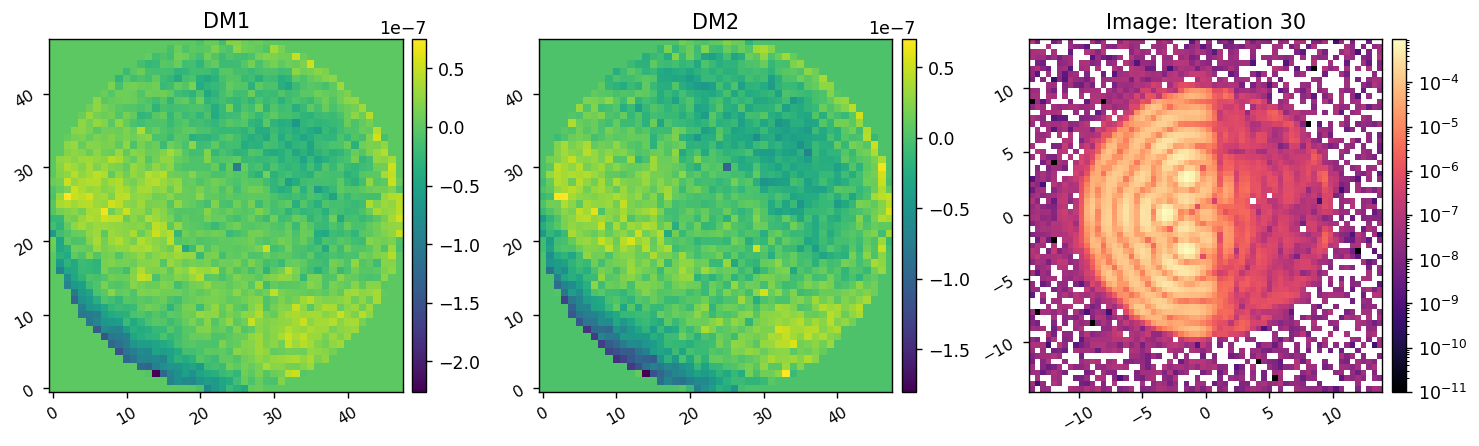

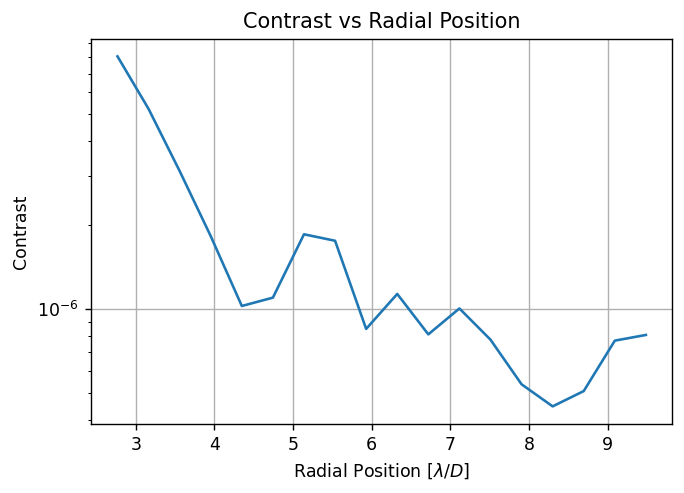

	Closed-loop iteration 31 / 36
	Mean NI of this iteration: 1.319e-06


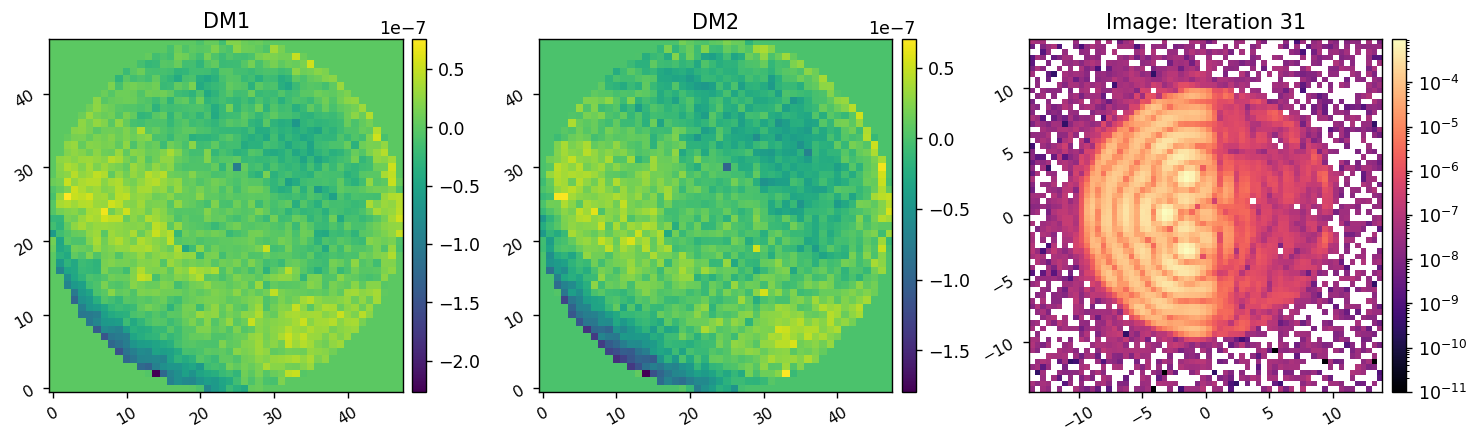

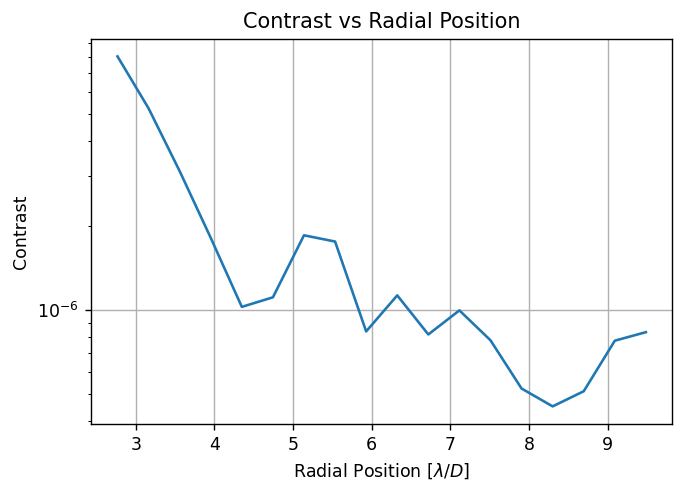

	Closed-loop iteration 32 / 36
	Mean NI of this iteration: 1.320e-06


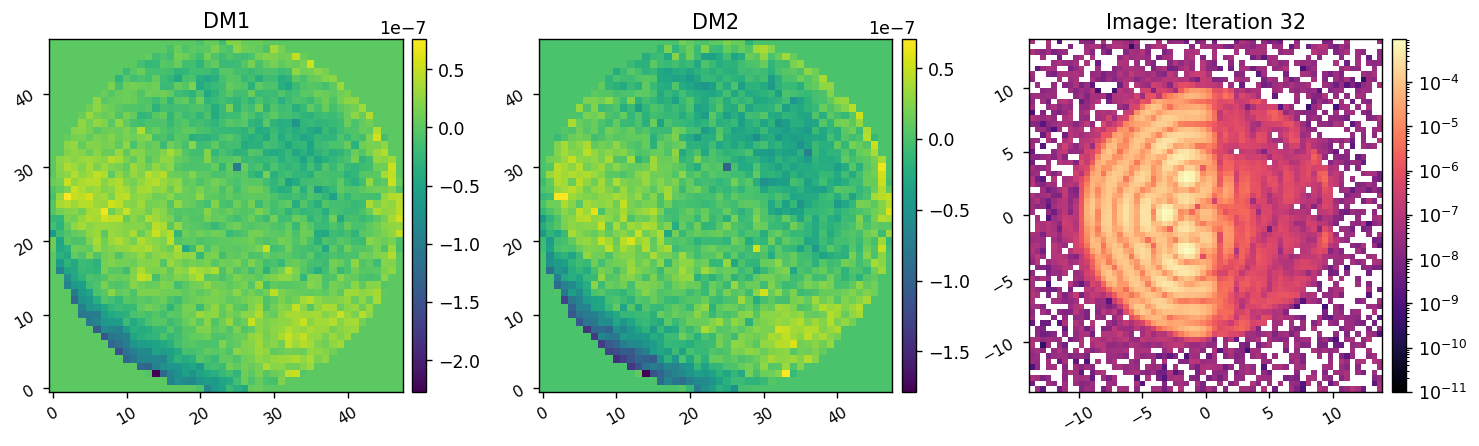

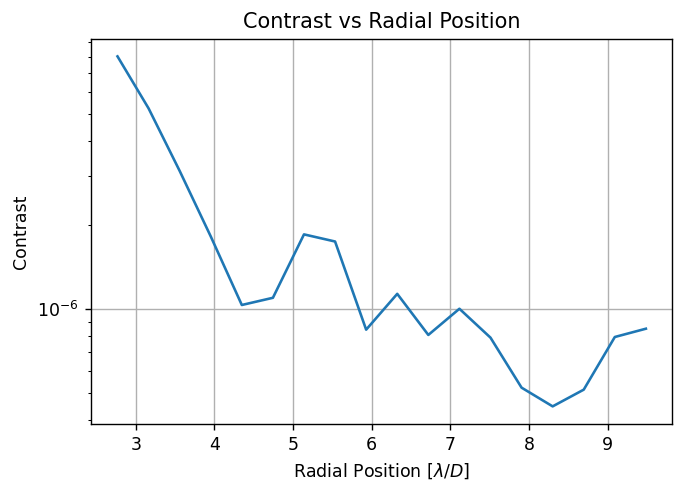

	Closed-loop iteration 33 / 36
	Mean NI of this iteration: 1.322e-06


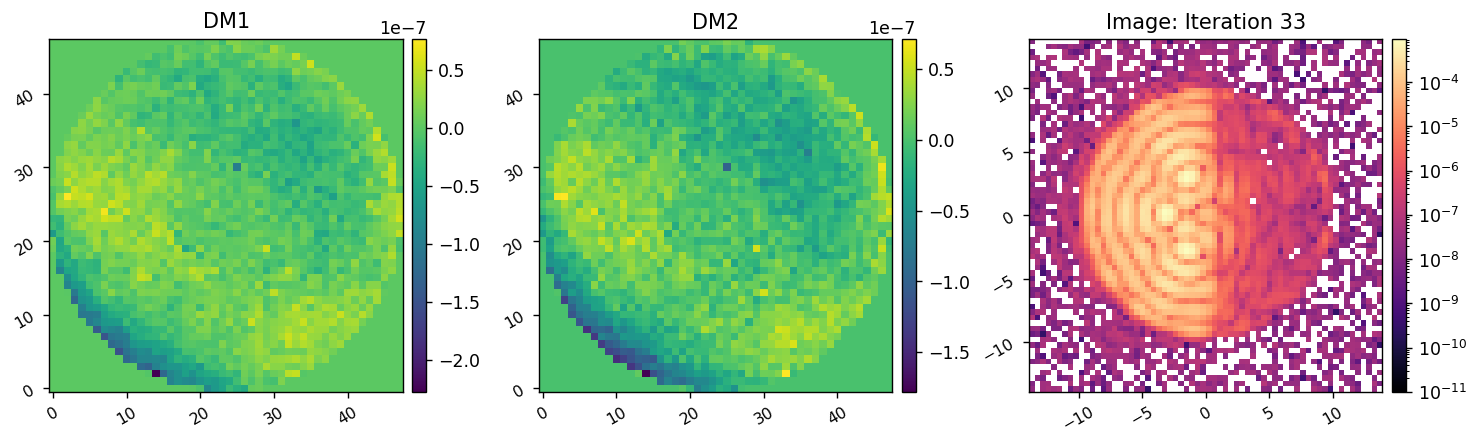

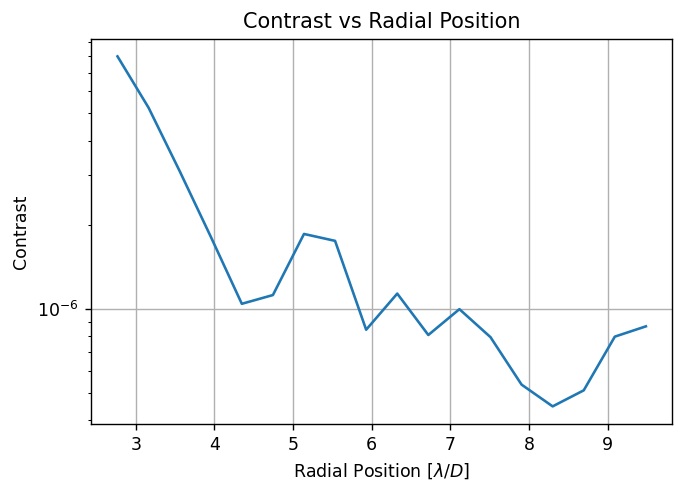

	Closed-loop iteration 34 / 36
	Mean NI of this iteration: 1.322e-06


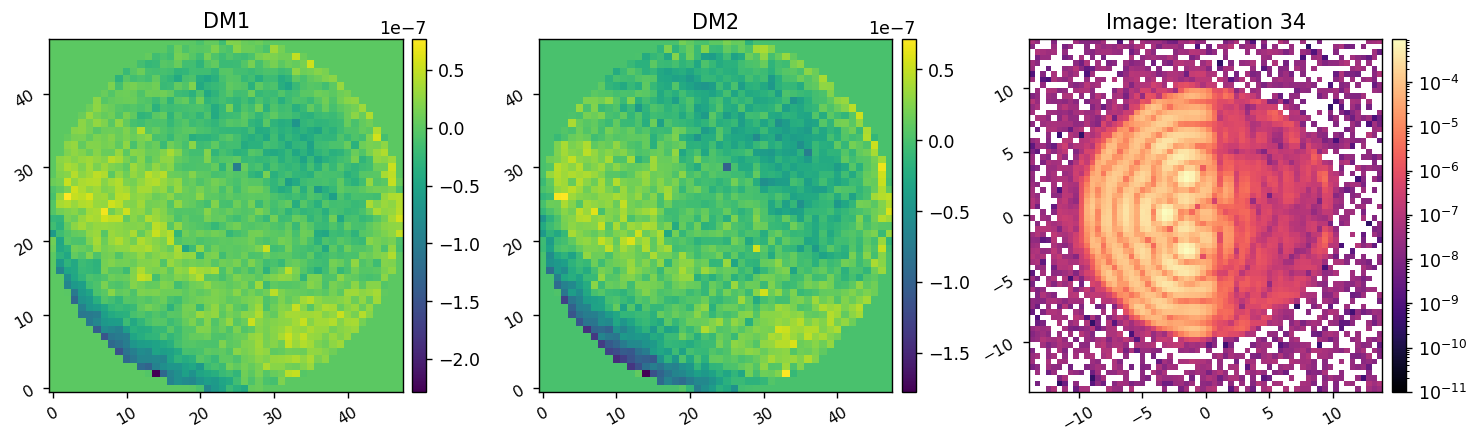

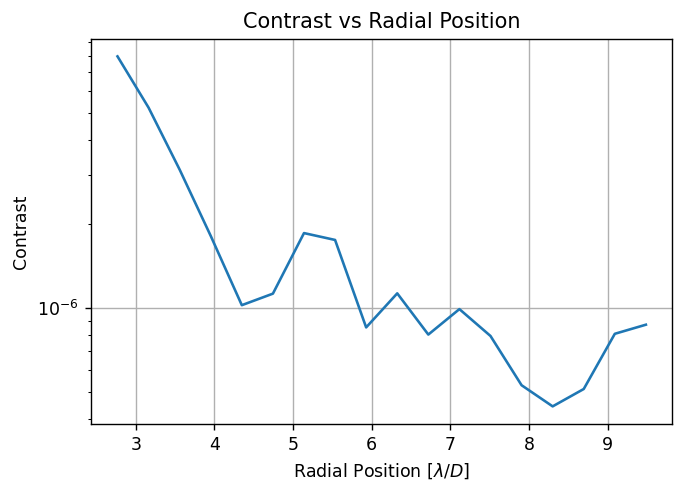

	Closed-loop iteration 35 / 36
	Mean NI of this iteration: 1.324e-06


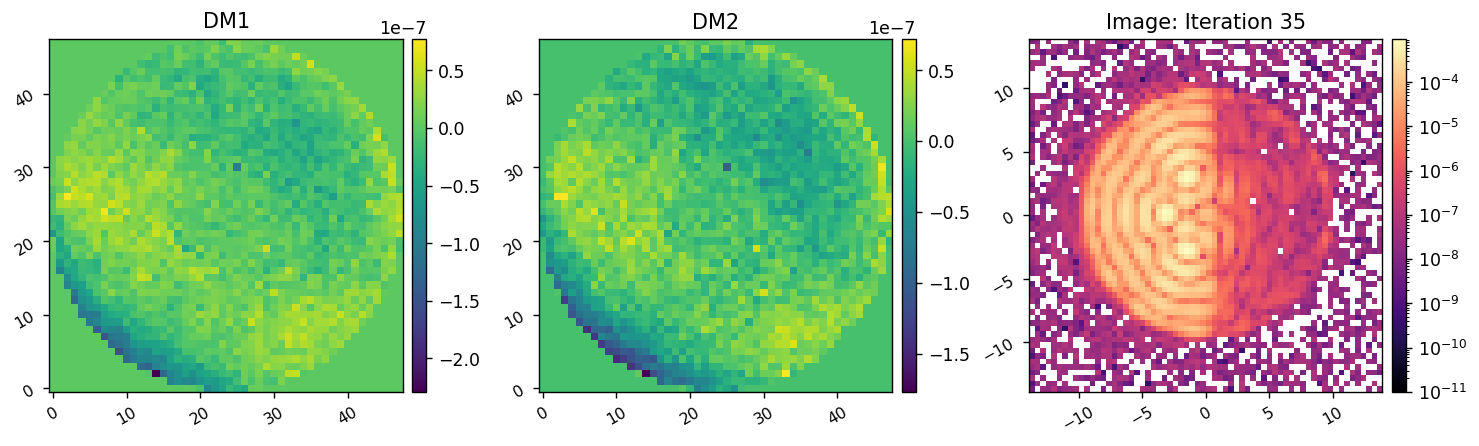

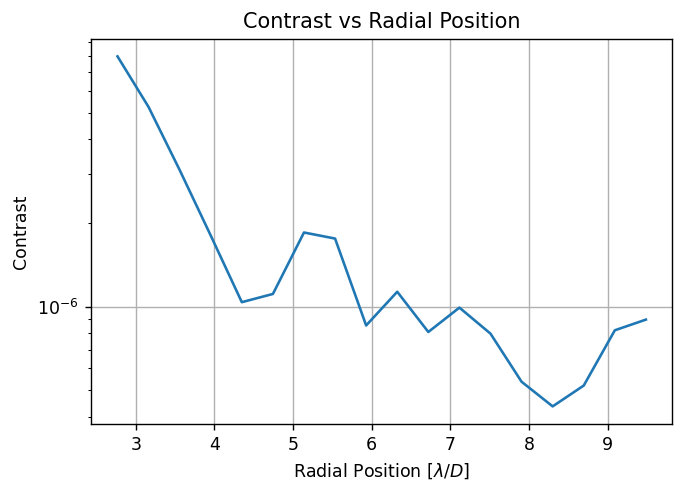

	Closed-loop iteration 36 / 36
	Mean NI of this iteration: 1.329e-06


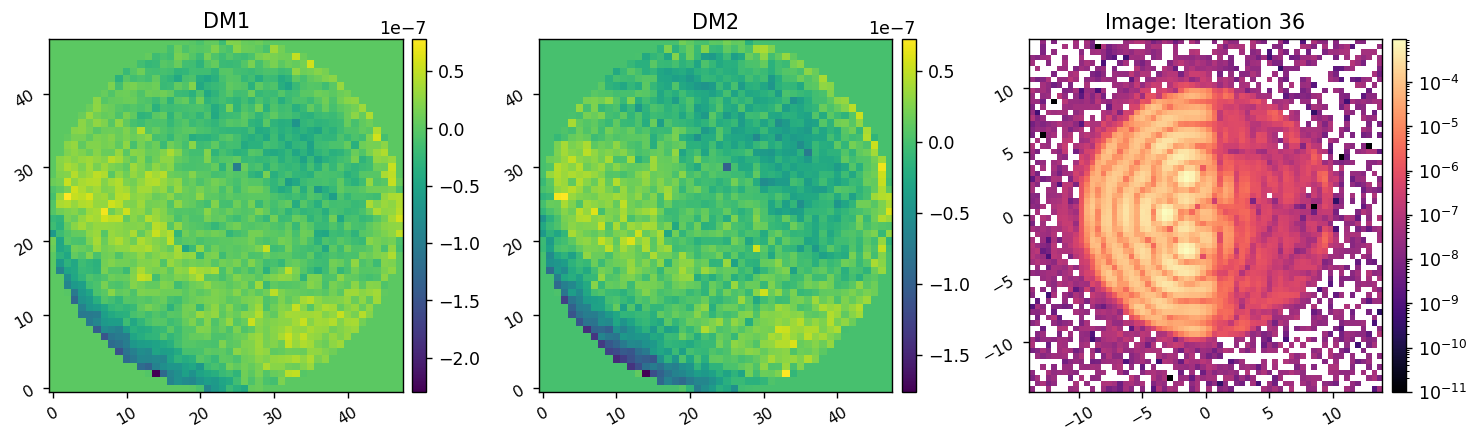

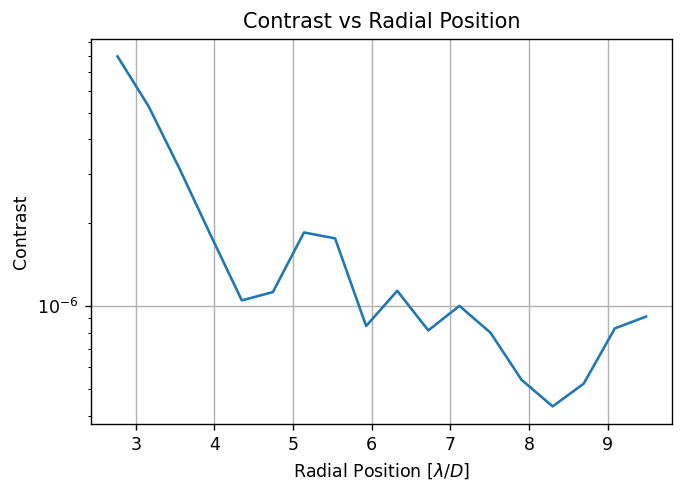

Closed loop for given control matrix completed in 38.858s.


In [36]:
Nitr = 10
reg_cond = 3e-3
control_matrix = utils.WeightedLeastSquares(response_matrix, rcond=reg_cond, weight_map=weight_map, nprobes=probe_modes.shape[0])
        
images, dm1_commands, dm2_commands = iefc_2dm.run(mode, 
                                                  control_matrix,
                                                  probe_modes, 
                                                  probe_amp, 
                                                  ensure_np_array(calib_modes),
                                                  control_mask, 
                                                  num_iterations=Nitr, 
#                                                   starting_iteration=0,
                                                  loop_gain=0.5, 
                                                  leakage=0,
                                                  plot_all=True,
                                                  plot_radial_contrast=True,
                                                  old_images=images,
                                                  old_dm1_commands=dm1_commands,
                                                  old_dm2_commands=dm2_commands,
                                                 )